# PROYECTO: PRONÓSTICO DE DEMANDA ENERGÉTICA CON SARIMA

## 1. El problema de negocio

La empresa es responsable de supervisar el proceso de generación y distribución de energía eléctrica en el estado de California en Estados Unidos.

Y lo que se busca es tener una operación eficiente, es decir que la oferta energética esté alineada con la **demanda esperada**. Una sobre-estimación de la demanda conlleva costos asociados al desperdicio de recursos o almacenamiento no aprovechado, mientras que una subestimación puede producir fallos en el suministro, afectando tanto a clientes residenciales como industriales.


## 2 - Objetivo del proyecto

Desarrollar un modelo predictivo de **corto plazo** (máximo 24 horas hacia el futuro) que, utilizando datos históricos de consumo horario, permita anticipar la demanda energética.

## 3 - Lectura de los datos

Se usará la API de la EIA. Después de solicitar las credenciales de acceso a la API se puede usar este código para extraer los datos:

In [1]:
# Leer serie de tiempo
import pandas as pd

df = pd.read_csv('demanda_electricidad_california_2019_2025.csv')
df

,period,subba,subba-name,parent,parent-name,value,value-units
0,2019-01-01 00:00:00,PGAE,Pacific Gas and Electric,CISO,California Independent System Operator,10440,megawatthours
1,2019-01-01 00:00:00,SCE,Southern California Edison - CISO,CISO,California Independent System Operator,10287,megawatthours
2,2019-01-01 00:00:00,SDGE,San Diego Gas and Electric - CISO,CISO,California Independent System Operator,2414,megawatthours
3,2019-01-01 00:00:00,VEA,Valley Electric Association - CISO,CISO,California Independent System Operator,75,megawatthours
4,2019-01-01 01:00:00,PGAE,Pacific Gas and Electric,CISO,California Independent System Operator,11256,megawatthours
...,...,...,...,...,...,...,...
229140,2025-07-19 23:00:00,SCE,Southern California Edison,CISO,California Independent System Operator,13931,megawatthours
229141,2025-07-20 00:00:00,PGAE,Pacific Gas and Electric,CISO,California Independent System Operator,11336,megawatthours
229142,2025-07-20 00:00:00,SCE,Southern California Edison,CISO,California Independent System Operator,14393,megawatthours
229143,2025-07-20 00:00:00,SDGE,San Diego Gas and Electric,CISO,California Independent System Operator,1491,megawatthours


## 4 - Análisis exploratorio y limpieza de datos preliminar

Comencemos leyendo la serie de tiempo:

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229145 entries, 0 to 229144
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   period       229145 non-null  object
 1   subba        229145 non-null  object
 2   subba-name   229145 non-null  object
 3   parent       229145 non-null  object
 4   parent-name  229145 non-null  object
 5   value        229145 non-null  int64 
 6   value-units  229145 non-null  object
dtypes: int64(1), object(6)
memory usage: 12.2+ MB


Columnas:

- "period": marca de tiempo
- "subba": sigla sub-balancing authority (sub-región encargada del suministro de energía)
- "subba-name": nombre completo de la sub-región
- "parent": siglas de la región encargada del suministro de energía (California)
- "parent-name": nombre completo de la región encargada del suministro de energía
- "value": la variable de interés a predecir (demanda de energía eléctrica)
- "value-units": unidades de la variable observada (MW/H)

Representemos la columna "period" en el formato "Datetime" de Pandas:

In [3]:
# Convertir period a datetime
df['period'] = pd.to_datetime(df['period'])

Al observar la serie de tiempo vemos que existen marcas de tiempo idénticas. Esto se debe a que la región de California contiene múltiples sub-regiones (columna "subba").

Agrupemos for "period" para que cada marca de tiempo aparezca sólo una vez. La función de agregación será "sum()" (la suma de la energía generada):

In [4]:
# Agrupar por "period"
df_gr = df.groupby(by='period')['value'].sum()
df_gr

period
2019-01-01 00:00:00    23216
2019-01-01 01:00:00    24947
2019-01-01 02:00:00    27655
2019-01-01 03:00:00    27676
2019-01-01 04:00:00    26853
                       ...  
2025-07-19 20:00:00    29380
2025-07-19 21:00:00    27763
2025-07-19 22:00:00    26659
2025-07-19 23:00:00    26438
2025-07-20 00:00:00    27344
Name: value, Length: 57291, dtype: int64

Y ordenemos cronológicamente la Serie de Tiempo (para evitar problemas más adelante):

In [5]:
df_gr = df_gr.sort_index(ascending=True)
df_gr

period
2019-01-01 00:00:00    23216
2019-01-01 01:00:00    24947
2019-01-01 02:00:00    27655
2019-01-01 03:00:00    27676
2019-01-01 04:00:00    26853
                       ...  
2025-07-19 20:00:00    29380
2025-07-19 21:00:00    27763
2025-07-19 22:00:00    26659
2025-07-19 23:00:00    26438
2025-07-20 00:00:00    27344
Name: value, Length: 57291, dtype: int64

En este punto podemos verificar si hay marcas de tiempo faltantes.

Para ello:
1. Generamos un índice ideal desde la fecha de inicio hasta la fecha de finalización (frecuencia horaria)
2. Reindexamos la serie usando este nuevo índice
3. Si hay marcas de tiempo faltantes aparecerán valores NaN. Así que simplemente debemos contar estas marcas

In [6]:
# Verificar si hay marcas de tiempo faltantes

# 1. Crear índice ideal
indice_completo = pd.date_range(start=df_gr.index.min(), end=df_gr.index.max(), freq='h')

# 2. Reindexar
df_gr_full = df_gr.reindex(indice_completo)

# 3. Realizar conteo de NaNs en la nueva serie
marcas_faltantes = df_gr_full[df_gr_full.isna()]
print(f'Marcas de tiempo faltantes: {len(marcas_faltantes)}')

Marcas de tiempo faltantes: 118


Efectivamente hay marcas de tiempo faltantes. Antes de realizar el manejo verifiquemos cómo están distribuidas (si se trata de bloques consecutivos o marcas aleatoriamente distribuidas a lo largo del tiempo):

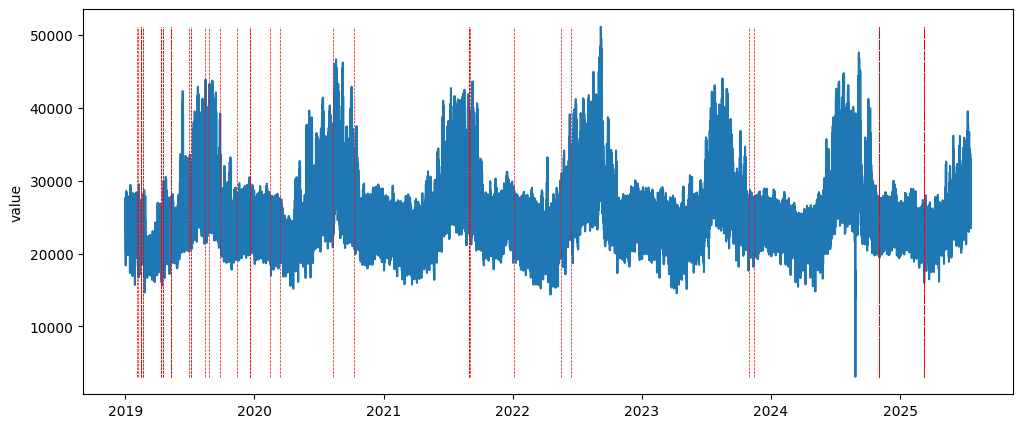

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear máscara con marcas de tiempo faltantes
mascara_faltantes = df_gr_full.isna()

# Graficar serie de tiempo (en azul)
fig, ax = plt.subplots(1,figsize=(12,5))
sns.lineplot(df_gr_full, ax=ax)

# Graficar las marcas faltantes como líneas verticales en rojo
ymin, ymax = df_gr_full.min(), df_gr_full.max()
for ts in marcas_faltantes.index:
    ax.vlines(ts, ymin, ymax, colors='red', linestyles='dashed', linewidth=0.5)

**Observación:**
- Las marcas de tiempo faltantes están distribuidas aleatoriamente y no como bloques consecutivos

Text(0, 0.5, 'Demanda energética')

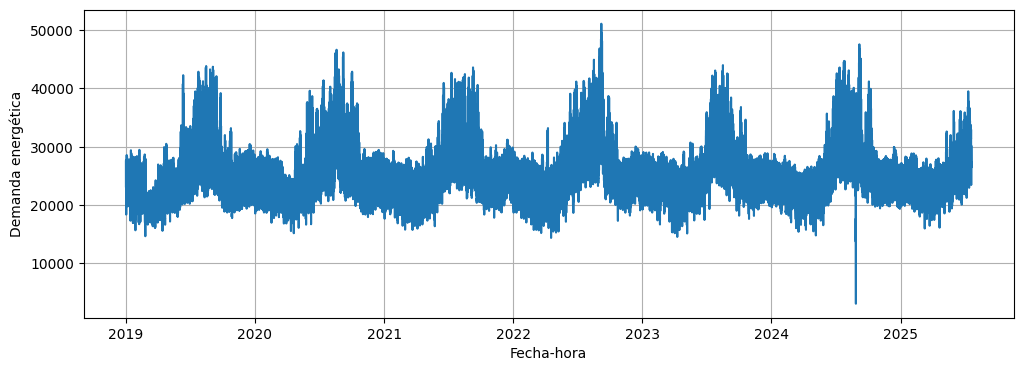

In [8]:
# Como los gaps parecen aleatorios los interpolaremos linealmente
df_interp = df_gr_full.interpolate(method='linear')

fig, ax = plt.subplots(1, figsize=(12,4))
ax.plot(df_interp)
ax.grid()
ax.set_xlabel('Fecha-hora')
ax.set_ylabel('Demanda energética')

In [9]:
# Verifiquemos que no hay NaNs
df_interp.isna().sum()

0

In [10]:
# Y verifiquemos que entre marcas de tiempo consecutivas hay exactamente 1 hora (3600 segundos)
time_diffs = df_interp.index.to_series().diff().dt.total_seconds()
time_diffs.describe()


count    57408.0
mean      3600.0
std          0.0
min       3600.0
25%       3600.0
50%       3600.0
75%       3600.0
max       3600.0
dtype: float64

¡Perfecto, todas las marcas de tiempo están distanciadas exactamente 1 hora!

In [11]:
# Usemos el método de Tukey para detectar valores extremos

q1 = df_interp.quantile(0.25)
q3 = df_interp.quantile(0.75)
iqr = q3-q1

outliers = df_interp[
    (df_interp < (q1-2*iqr)) # Nos interesan sólo los outliers cercanos a Q1
]
outliers

2024-08-27 02:00:00    3171.0
2024-08-27 03:00:00    3399.0
2024-08-27 04:00:00    3406.0
2024-08-27 05:00:00    3270.0
2024-08-27 06:00:00    3088.0
Freq: h, Name: value, dtype: float64

Realicemos el manejo de estos outliers:

1. Los marcamos como NaN
2. Usamos interpolación lineal
3. Al final graficamos el resultado para verificar que ya no están presentes

<Axes: >

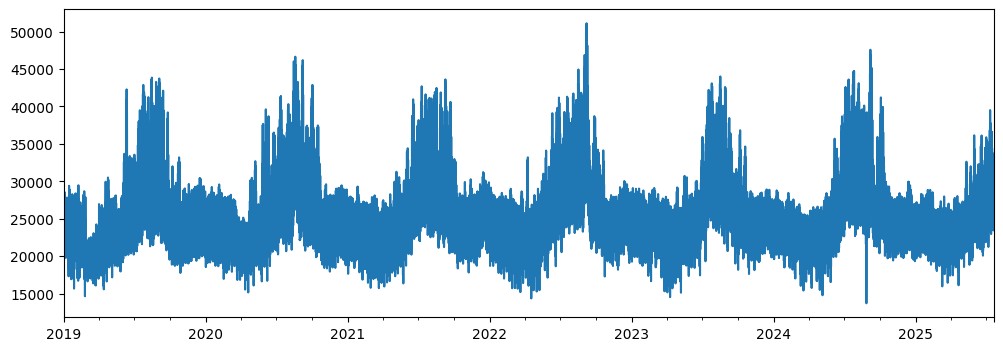

In [12]:
# 1. Marquemos estos outliers como NaN
idxs = df_interp.index.isin(outliers.index)
df_interp.iloc[idxs] = None

# 2. Ahora interpolemos estos valores linealmente
serie = df_interp.interpolate(method='linear')

# 3. Y grafiquemos la serie para verificar que no hay valores extremos
serie.plot(figsize=(12,4))

## 5 - Análisis exploratorio detallado

El objetivo de esta segunda parte del análisis es determinar el modelo de pronóstico más adecuado, tomando como base las características de la Serie.

Comencemos descomponiendo la serie en tendencia y estacionalidad:

In [13]:
# Tendencia y estacionalidad usando modelos aditivos y multiplicativos
from statsmodels.tsa.seasonal import seasonal_decompose

# Descomposiciones aditiva y multiplicativa
dec_add = seasonal_decompose(serie, model="additive")
dec_mul = seasonal_decompose(serie, model="multiplicative")

Y generemos los gráficos comparativos en cada método:

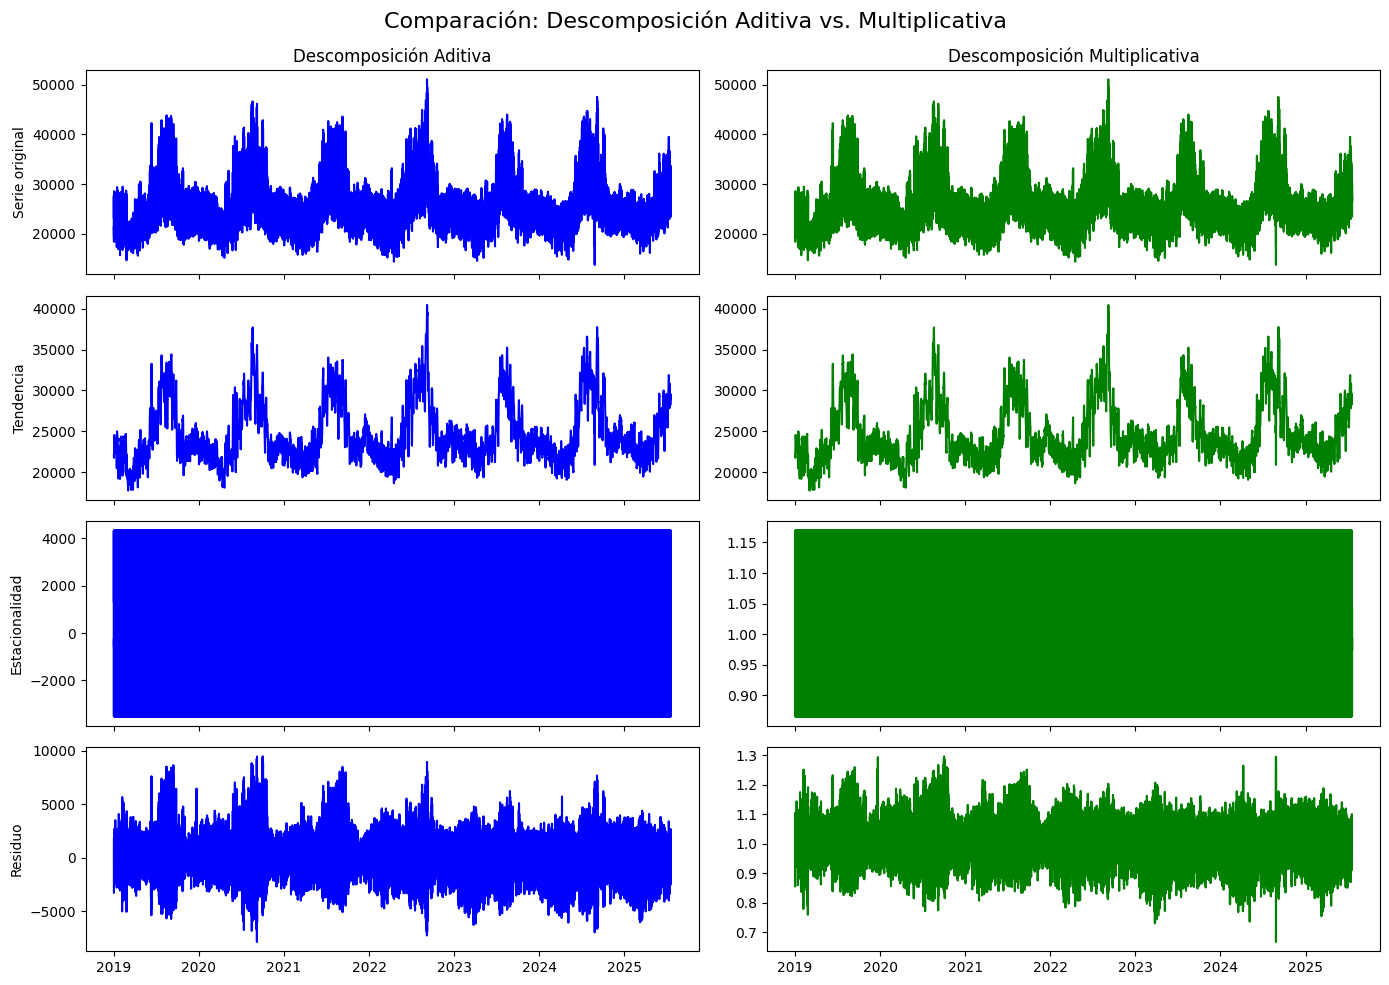

In [14]:
# Crear figura con 4 filas y 2 columnas (1 por modelo)
fig, axes = plt.subplots(4, 2, figsize=(14, 10), sharex=True)

# Títulos por columna
axes[0, 0].set_title("Descomposición Aditiva")
axes[0, 1].set_title("Descomposición Multiplicativa")

# Etiquetas de las filas
componentes = ['Serie original', 'Tendencia', 'Estacionalidad', 'Residuo']
datos_add = [dec_add.observed, dec_add.trend, dec_add.seasonal, dec_add.resid]
datos_mul = [dec_mul.observed, dec_mul.trend, dec_mul.seasonal, dec_mul.resid]

for i in range(4):
    axes[i, 0].plot(datos_add[i], color='blue')
    axes[i, 1].plot(datos_mul[i], color='green')
    axes[i, 0].set_ylabel(componentes[i])

# Ajustar layout
plt.tight_layout()
plt.subplots_adjust(top=0.92)
fig.suptitle("Comparación: Descomposición Aditiva vs. Multiplicativa", fontsize=16);

Dibujemos únicamente un año para poder ver en detalle los comportamientos de cada componente:

Text(0.5, 0.98, 'Comparación: Descomposición Aditiva vs. Multiplicativa')

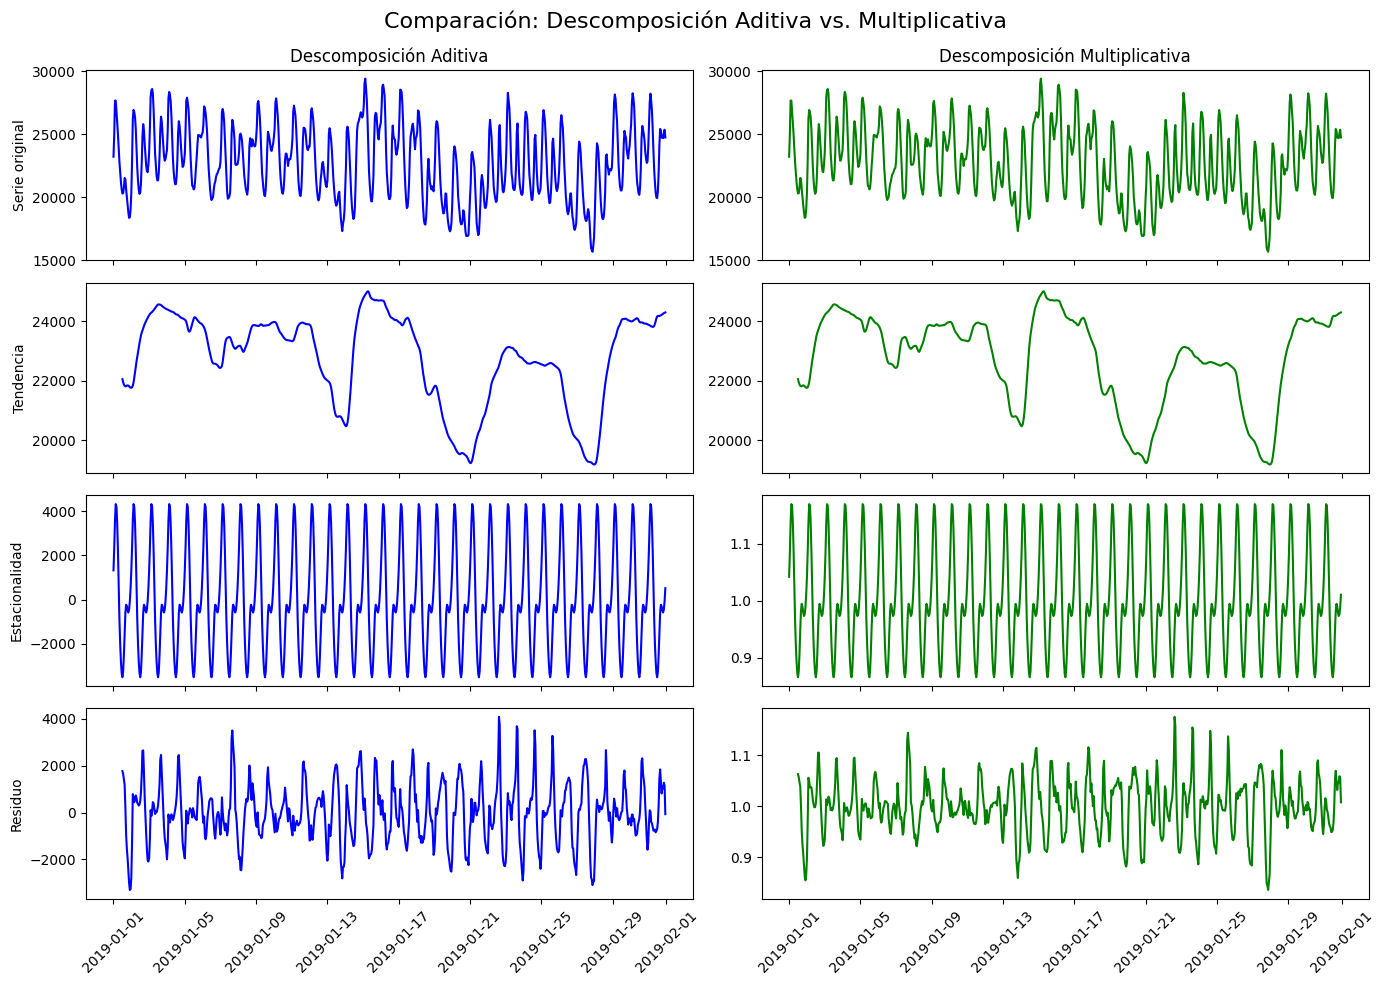

In [15]:
# Crear figura con 4 filas y 2 columnas (1 por modelo)
fig, axes = plt.subplots(4, 2, figsize=(14, 10), sharex=True)

# Títulos por columna
axes[0, 0].set_title("Descomposición Aditiva")
axes[0, 1].set_title("Descomposición Multiplicativa")

# Etiquetas de las filas
periodo = '2019-01'
componentes = ['Serie original', 'Tendencia', 'Estacionalidad', 'Residuo']
datos_add = [dec_add.observed[periodo], dec_add.trend[periodo], dec_add.seasonal[periodo], dec_add.resid[periodo]]
datos_mul = [dec_mul.observed[periodo], dec_mul.trend[periodo], dec_mul.seasonal[periodo], dec_mul.resid[periodo]]

for i in range(4):
    axes[i, 0].plot(datos_add[i], color='blue')
    axes[i, 1].plot(datos_mul[i], color='green')
    axes[i, 0].set_ylabel(componentes[i])

# Rotar etiquetas del eje X solo en la última fila de subplots
for ax in axes[-1, :]:  # toma ambos ejes en la última fila
    for label in ax.get_xticklabels():
        label.set_rotation(45)

# Ajustar layout
plt.tight_layout()
plt.subplots_adjust(top=0.92)
fig.suptitle("Comparación: Descomposición Aditiva vs. Multiplicativa", fontsize=16)

Realmente no se observa una tendencia clara pero sí resulta interesante ver que cualquier descomposición arroja una estacionalidad aparente.

Analicemos esta estacionalidad usando la función de autocorrelación:

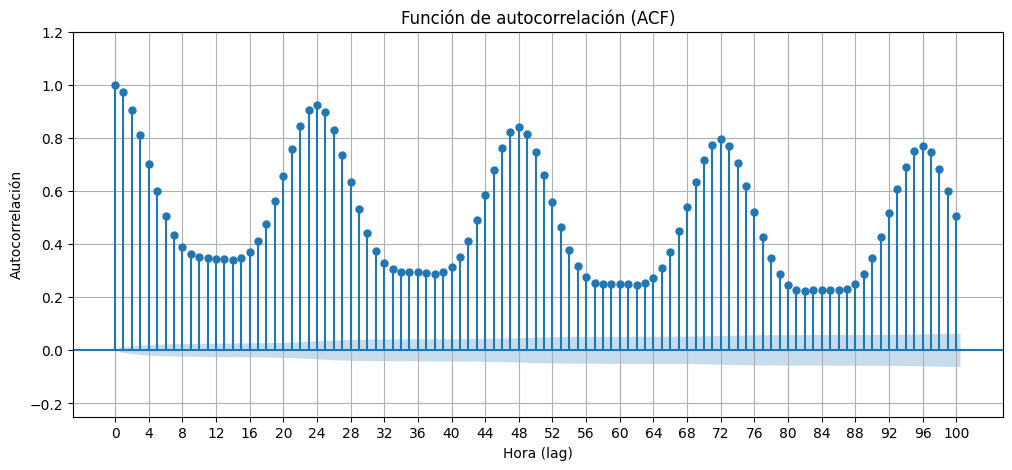

In [16]:
# Análisis de posible estacionalidad usando la función de autocorrelación
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np

fig, ax = plt.subplots(1, figsize=(12,5))
fig = plot_acf(serie, lags=100, ax=ax)

# Personalizar figura
xticks = np.arange(0,101,4) # Etiqueta eje horizontal cada 4 horas
ax.grid()
ax.set_ylim([-0.25, 1.2])
ax.set_xticks(xticks)
ax.set_xlabel('Hora (lag)')
ax.set_ylabel('Autocorrelación')
ax.set_title('Función de autocorrelación (ACF)');


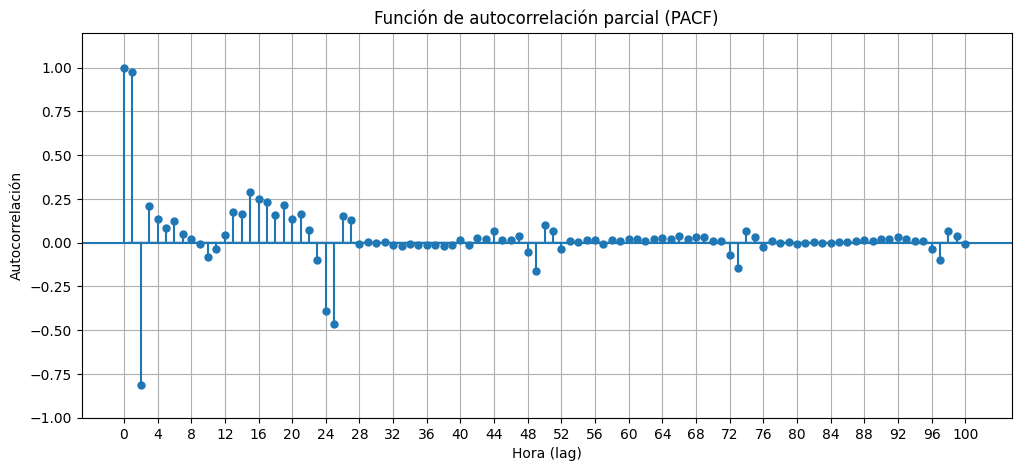

In [27]:
# Análisis de posible estacionalidad usando la función de autocorrelación parcial
from statsmodels.graphics.tsaplots import plot_pacf
import numpy as np

fig, ax = plt.subplots(1, figsize=(12,5))
fig = plot_pacf(serie, lags=100, ax=ax)

# Personalizar figura
xticks = np.arange(0,101,4) # Etiqueta eje horizontal cada 4 horas
ax.grid()
ax.set_ylim([-1, 1.2])
ax.set_xticks(xticks)
ax.set_xlabel('Hora (lag)')
ax.set_ylabel('Autocorrelación')
ax.set_title('Función de autocorrelación parcial (PACF)');


**Observaciones:**
- Es clara la presencia de estacionalidad en múltiplos enteros de 24 horas (24, 48, 72, 96, etc...)

Veamos un poco más en detalle esta estacionalidad. Hagamos gráficos estacionales de:

- Nivel de demanda (eje "y") para las diferentes horas (eje "x") y los diferentes meses del año ("hue"). Con esto podremos determinar si los patrones de consumo se repiten independientemente del mes del año
- Nivel de demanda (eje "y") para las diferentes horas (eje "x") y los diferentes años ("hue"). Con esto podremos determinar si los patrones de consumo se repiten independientemente del año

Para ello crearemos las columnas "hora", "mes" y "año" en la serie de tiempo:

In [18]:
# Preparar dataset para gráficos estacionales
ts = serie.copy().to_frame()

# Agregar columnas mes y año
ts['hora'] = ts.index.hour
ts['mes'] = ts.index.month
ts['año'] = ts.index.year


<Axes: xlabel='hora', ylabel='value'>

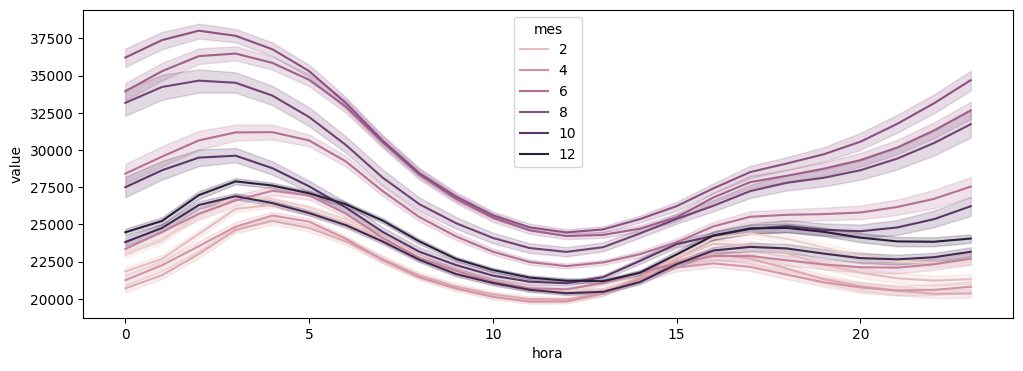

In [19]:
# Gráfico estacional nivel de demanda vs. horas y meses
fig, ax = plt.subplots(figsize=(12,4))
sns.lineplot(data=ts, x='hora',y='value', hue='mes', ax=ax)

**Observaciones:**
1. Independientemente del mes, la hora de máximo consumo es entre 3:00 am y 3:30 am y la de menor consumo es cerca de las 11 am
2. Sin embargo, lo que cambia entre un mes y otro es que el máximo y el mínimo son diferentes: cerca del mes 8 (agosto) el máximo es mayor que en cualquier otro mes, mienetras que el mínimo más pequeño se da en los meses 1 y 2
3. Esto indica que el patrón intradía (dentro del día) es estacional y consistente: todos los días siguen más o menos el mismo comportamiento de consumo.

Ahora algo similar pero en lugar de meses incluiremos los años:

<Axes: xlabel='hora', ylabel='value'>

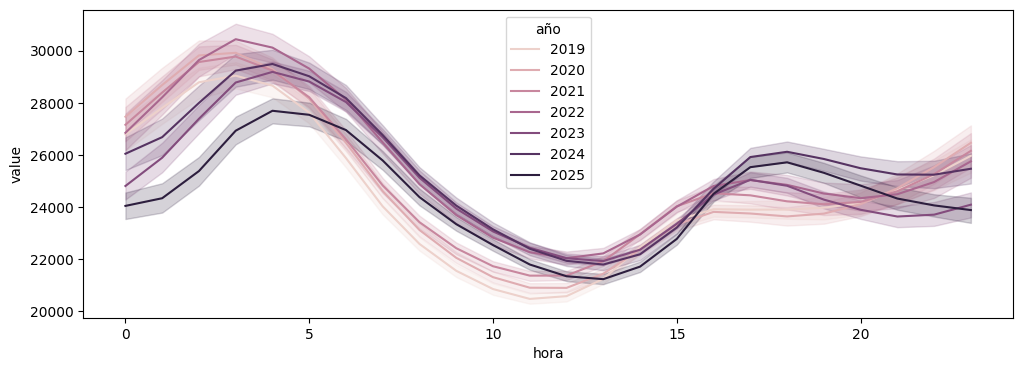

In [20]:
# Gráfico estacional nivel de demanda vs. horas y años
fig, ax = plt.subplots(figsize=(12,4))
sns.lineplot(data=ts, x='hora',y='value', hue='año', ax=ax)

Lo anterior nos permite reconfirmar el comportamiento periódico de la serie, con una demanda que crece hacia las horas de la madrugada y que decrece hacia la media noche.

De hecho, si hacemos este gráfico estacional por ejemplo para un único mes, veremos este patrón claramente:

Text(0, 0.5, 'Demanda energética')

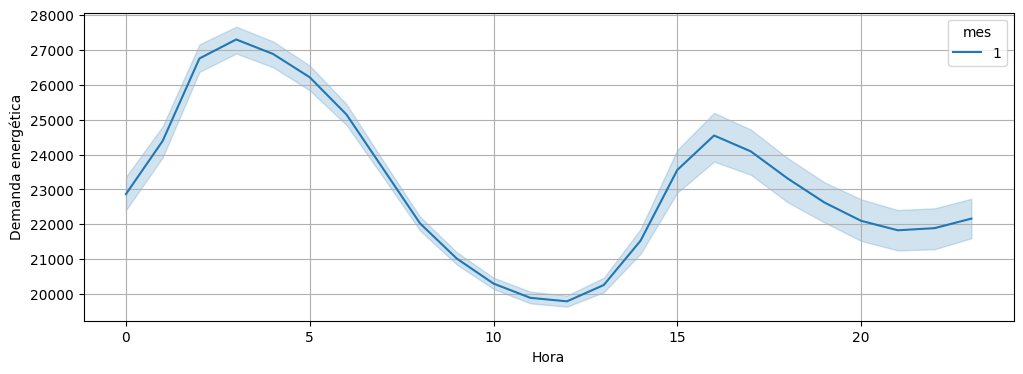

In [21]:
# Gráfico estacional nivel de demanda vs. horas y meses
fig, ax = plt.subplots(figsize=(12,4))
sns.lineplot(data=ts.loc['2020-01'], x='hora',y='value', hue='mes', ax=ax);
ax.grid()
ax.set_xlabel('Hora')
ax.set_ylabel('Demanda energética')

## 6 - Selección posible modelo

Nos interesa pronosticar a nivel horario y de hecho acabamos de verificar que ¡la serie tiene una frecuencia de 24 horas!

Y en resumen tenemos hasta este punto:

- Un horizonte de predicción: hasta 24 horas
- Frecuencia de los datos: horaria
- Estacionalidad: diaria (cada 24 horas)
- Un registro de 6 años de datos (suficiente para entrenar modelos clásicos o de Machine o Deep Learning)

En este caso podemos delimitar las opciones a estos modelos:

| Modelo | Características | Ventajas | Desventajas |
| ------ | --------------- | -------- | ----------- |
| SARIMA | Clásico y diseñado para series con tendencia y estacionalidad | Entrenamiento rápido, es fácil ajustar hiper-parámetros | Acepta a la entrada sólo una variable (modelo univariado) |
| XGBoost, LSTM | Machine/Deep Learning y diseñado para problemas de regresión no lineal | Puede aceptar múltiples variables a la entrada | Requiere ingeniería de características y no funciona tan bien para series con alto grado de estacionalidad |

En este caso optaremos por SARIMA pues:

- Nuestros datos tienen una estacionalidad fuerte
- No es un problema multivariado
- Tenemos datos suficientes (6 años con frecuencia horaria)


## 7 - Modelo base

Construiremos un modelo base que nos servirá como referencia para comparar el desempeño del modelo SARIMA.

In [22]:
# Subdividir datos en entrenamiento y prueba
H = 24 # Horizonte del pronóstico

# Train-Test split (últimas 24h como test)
train = serie.iloc[:-H]
test = serie.iloc[-H:]

In [23]:
y_pred = train.shift(H)
print(y_pred.head(48))

2019-01-01 00:00:00        NaN
2019-01-01 01:00:00        NaN
2019-01-01 02:00:00        NaN
2019-01-01 03:00:00        NaN
2019-01-01 04:00:00        NaN
2019-01-01 05:00:00        NaN
2019-01-01 06:00:00        NaN
2019-01-01 07:00:00        NaN
2019-01-01 08:00:00        NaN
2019-01-01 09:00:00        NaN
2019-01-01 10:00:00        NaN
2019-01-01 11:00:00        NaN
2019-01-01 12:00:00        NaN
2019-01-01 13:00:00        NaN
2019-01-01 14:00:00        NaN
2019-01-01 15:00:00        NaN
2019-01-01 16:00:00        NaN
2019-01-01 17:00:00        NaN
2019-01-01 18:00:00        NaN
2019-01-01 19:00:00        NaN
2019-01-01 20:00:00        NaN
2019-01-01 21:00:00        NaN
2019-01-01 22:00:00        NaN
2019-01-01 23:00:00        NaN
2019-01-02 00:00:00    23216.0
2019-01-02 01:00:00    24947.0
2019-01-02 02:00:00    27655.0
2019-01-02 03:00:00    27676.0
2019-01-02 04:00:00    26853.0
2019-01-02 05:00:00    25940.0
2019-01-02 06:00:00    24983.0
2019-01-02 07:00:00    23853.0
2019-01-

In [24]:
from sklearn.metrics import mean_absolute_percentage_error as mape, root_mean_squared_error as rmse

# Evaluación
mape_base = mape(train[H:], y_pred[H:])
rmse_base = rmse(train[H:], y_pred[H:])

print(f"Modelo base (Seasonal Naïve) - MAPE: {100*mape_base:.2f}% - RMSE: {rmse_base:.4f} MW")


Modelo base (Seasonal Naïve) - MAPE: 5.07% - RMSE: 1822.1066 MW


## 8 - Implementación modelo SARIMA

In [26]:
from statsmodels.tsa.stattools import adfuller

# Función para probar estacionariedad
def prueba_estacionariedad(serie, serie_name):
    # Realizar prueba
    adf = adfuller(serie.dropna())
    
    # Extraer el valor de p    
    p = adf[1]

    print(f'Serie: {serie_name}')
    if p < 0.05:
        # Se rechaza la hipótesis nula: la serie es estacionaria
        print(f'\tLa serie es estacionaria porque p = {p:.4f} < 0.05')
    else:
        # Se acepta la hipótesis nula: la serie es NO estacionaria
        print(f'\tLa serie NO es estacionaria porque p = {p:.4f} >= 0.05')
    print('-'*20)

# Aplicar prueba para serie original, diferenciada (lag 1) y diferenciada estacionalmente (24 horas)
prueba_estacionariedad(ts['value'], 'Serie original')


Serie: Serie original
	La serie es estacionaria porque p = 0.0000 < 0.05
--------------------


Además de la estacionariedad, en el análisis exploratorio confirmamos que la serie tiene estacionalidad. Así que se cumplen los supuestos para desarrollar el modelo SARIMA.

- d=0 porque la serie original es estacionaria
- D=0 porque la serie diferenciada con lags de 24 horas es estacionaria
- s=24 porque es el periodo de la estacionalidad
- Q=1 porque hay un pico en lag=24 en la ACF
- P=1 porque tengo picos en la PACF en múltiplos enteros de 25 (25, 50, ...)

Para determinar p y q:

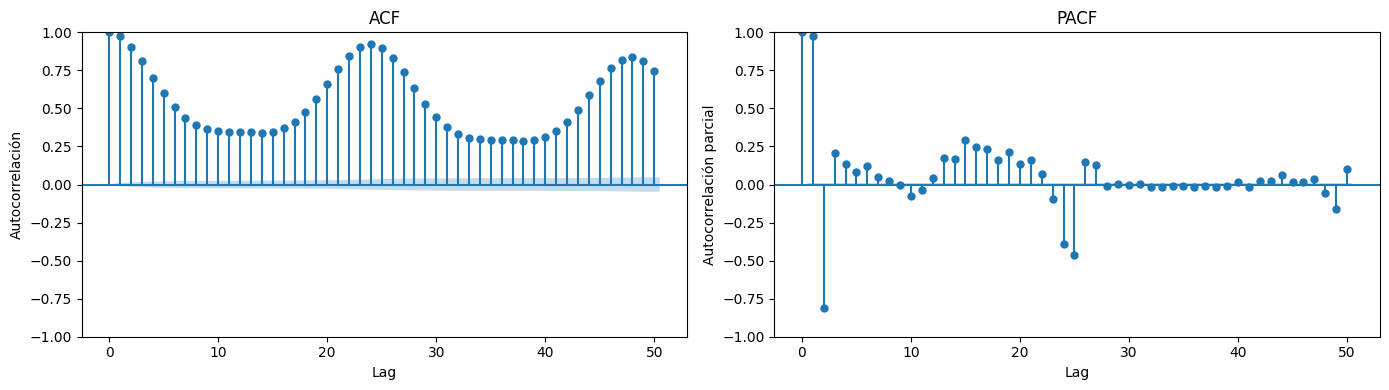

In [28]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Serie ya estacionaria (sin diferenciación adicional porque d=0, D=0)

# Graficar ACF y PACF hasta, por ejemplo, 50 lags
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(train, lags=50, ax=axes[0])
axes[0].set_title("ACF")
axes[0].set_xlabel("Lag")
axes[0].set_ylabel("Autocorrelación")

plot_pacf(train, lags=50, ax=axes[1], method='ywm')
axes[1].set_title("PACF")
axes[1].set_xlabel("Lag")
axes[1].set_ylabel("Autocorrelación parcial")

plt.tight_layout()

- La función de autocorrelación parcial no tiene caidas abruptas. Por tanto no hay un orden auto-regresivo aparente y asumimos p=1
- La función de autocorrelación tampoco tiene cortes o caidas abruptas. Por tanto asumimos que q=0.

In [30]:
# Fijemos entonces los parámetros finales para SARIMA
d = 0
D = 0
s = 24
Q = 1
P = 1
p = 1
q = 0

Construyamos el modelo SARIMA con diferentes ventanas de entrada. Asumiremos ventanas de 1 semana, 2 semanas, 1 mes y dos meses y mantendremos fijo el horizonte del pronóstico en 24 horas a futuro.

Evaluaremos cada modelo construido usando RMSE y MAPE:

In [ ]:
# Librería para implementar y evaluar el modelo
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Hiperparámetro "ventana de entrada"
VENTANAS_HORAS = [24*7, 24*15, 24*30, 24*60, ]  # 1 semana, 2 semanas, 1 mes, 2 meses
H = 24  # Predecir las próximas 24 horas (desde el punto de vista operativo le interesa a la empresa)

resultados_mape = []
resultados_rmse = []
serie = train.copy()

for ventana in VENTANAS_HORAS:
    print(f"\nEvaluando ventana: {ventana} horas ({ventana//24} días)")
    
    # Subsets para entrenamiento y validación
    train_ventana = train[-(ventana + H):-H]
    val_ventana = train[-H:]

    # Ajustar SARIMA usando los valores de p, d, q, P, D, Q y s estimados anteriormente
    model = SARIMAX(train_ventana, order=(p,d,q), seasonal_order=(P,D,Q,s))
    model_fit = model.fit(disp=False)

    # Pronóstico
    forecast = model_fit.forecast(steps=H)

    # Evaluación
    error_mape = mape(val_ventana, forecast)
    error_rmse = rmse(val_ventana, forecast)
    resultados_mape.append((ventana, error_mape))
    resultados_rmse.append((ventana, error_rmse))

# Mostrar resultados
print("\nResumen de errores (menor es mejor):")
for ventana, error_mape in resultados_mape:
    print(f"- Ventana: {ventana} h → MAPE: {error_mape:.5f}")

for ventana, error_rmse in resultados_rmse:
    print(f"- Ventana: {ventana} h → RMSE: {error_rmse:.5f}")


Evaluando ventana: 168 horas (7 días)


/Users/miguel/.pyenv/versions/academy/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Evaluando ventana: 360 horas (15 días)


/Users/miguel/.pyenv/versions/academy/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'



Evaluando ventana: 720 horas (30 días)


/Users/miguel/.pyenv/versions/academy/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'



Evaluando ventana: 1440 horas (60 días)

Resumen de errores (menor es mejor):
- Ventana: 168 h → MAPE: 0.01353
- Ventana: 360 h → MAPE: 0.01385
- Ventana: 720 h → MAPE: 0.02113
- Ventana: 1440 h → MAPE: 0.01877
- Ventana: 168 h → RMSE: 544.78458
- Ventana: 360 h → RMSE: 560.00583
- Ventana: 720 h → RMSE: 859.44102
- Ventana: 1440 h → RMSE: 755.19334


**Observaciones:**

- La ventana de 168 horas arroja el RMSE más bajo (544.8 MW)
- La ventana de 168 horas arroja igualmente el MAPE más bajo (1.3%)

Así que este modelo será el seleccionado. Para este modelo el desempeño es mucho mejor que el modelo base:

- MAPE base vs. MAPE modelo SARIMA: 4.13% vs. 1.3%
- RMSE base vs. RMSE modelo SARIMA: 1757.2 MW vs. 544.8 MW

Vamos por buen camino. Ahora analicemos los residuales.

## 6 - Análisis de residuales

In [ ]:
# Entrenemos el modelo final
# Fijemos entonces los parámetros finales para SARIMAX
d = 0
D = 0
s = 24
Q = 1
P = 1
p = 1
q = 0

VENTANA = 24*7
H = 24

train_ventana = train[-(VENTANA + H):-H]
val_ventana = train[-H:]

modelo = SARIMAX(train_ventana, order=(p,d,q), seasonal_order=(P,D,Q,s)).fit(disp=False)

# Predicción "in-sample" (sobre el set de entrenamiento)
pred_is = modelo.predict()

# Residuales (sin incluir el primer pronóstico pues es igual a cero)
residuales = train_ventana[1:] - pred_is[1:]

# Dibujar distribución
print("Media de los residuos:", residuales.mean())
print("Desviación estándar:", residuales.std())

sns.histplot(residuales, kde=True, stat="density", bins=30, color="skyblue");


Los residuales:
- NO tienen una media de cero sino del orden de -49 MW. Esto quiere decir que los pronósticos tienden a **sobre-estimar**  los valores reales en 49 MW en promedio
- La desviación de los residuales es de 485 MW, lo cual es relativamente bajo teniendo en cuenta que la demanda está en el orden de los 28.000 MW (es decir la desviación estándar es de 1.7% del nivel medio de la demanda)

Veamos qué ocurre con la función de autocorrelación:

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
plot_acf(residuales, lags=100, zero=False, auto_ylims=True, ax=ax)
ax.grid(True)

**Observaciones:**
- Existen varios componentes relativamente grandes en la autocorrelación: a 1 hr, 2 hr y 6 hr.
- Esto quiere decir que el modelo SARIMA no logra capturar en su totalidad estos componentes de la serie

## 7 - Pronósticos sobre el set de prueba

In [ ]:
# Entrenar el modelo con la totalidad del set de datos disponible ("serie")
train_ventana = train[-VENTANA:] # Se entrena sólo con las últimas 24*7 = 168 horas (7 días)
modelo = SARIMAX(train_ventana, 
                 order=(p,d,q), 
                 seasonal_order=(P,D,Q,s),
                 enforce_stationarity=False, # Porque puede ser que esta porción de la serie no sea del todo estacionaria
                 ).fit(disp=False)

In [ ]:
# Usaremos "get_forecast" en lugar de "forecast" para extraer los intervalos de predicción
prons = modelo.get_forecast(steps=H)
prons_df = prons.summary_frame(alpha=0.05) # Intervalo de predicción del 95%
prons_df

In [ ]:
prons_df.index

In [ ]:
# Graficar serie de prueba, pronósticos e intervalo de predicción
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(test, linestyle='--', label='Set de prueba')
sns.lineplot(prons_df, x=prons_df.index, y="mean", color='red', label=f'Pronostico {H} horas con SARIMA')
plt.fill_between(x=prons_df.index, 
                 y1=prons_df["mean_ci_lower"], 
                 y2=prons_df["mean_ci_upper"], 
                 color = 'red',
                 alpha = 0.2,
                 label="Intervalo de predicción del 95%")
ax.set_xlabel('Fecha')
ax.set_ylabel('Demanda (MW)')
ax.grid(True)
ax.legend(loc="lower left");

Observamos que efectivamente la demanda tiende a estar sobre-estimada, lo cual coincide con el análisis de residuales realizado anteriormente.

## 8 - Posibles mejoras

El análisis de residuales mostró una sobre-estimación de la demanda y valores relativamente altos en la ACF, a 1, 2 y 6 horas.

Algunas sugerencias de mejora:

- Ajustar los parámetros p, q, d, P, Q y D usando por ejemplo herramientas como "pmdarima"
- Incluir variables exógenas como por ejemplo días festivos lo cual podría reducir el sesgo
- Puede haber estacionalidades de 6 hrs presentes. SARIMA está diseñado para modelar sólo un componente estacional (el de 24 horas que usamos en este proyecto), así que se podrían usar alternativas como TBATS.

